# House price prediction

### Business objective:
        Create model to predict price of houses for given attributes.

In [1]:
#import libraries

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn import linear_model, metrics
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import RFE
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score


import statsmodels.api as sm  
from statsmodels.stats.outliers_influence import variance_inflation_factor


## 1. Data understanding and cleaning:

In [2]:
# Reading data file
# df - main dataframe 
df = pd.read_csv('train.csv')
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [3]:
df.shape

(1460, 81)

### Dealing with NULL values

In [4]:
# getting percentage of null value
null_col=round(100*df.isnull().sum()/len(df.index),2)
null_col[null_col!=0]

LotFrontage     17.74
Alley           93.77
MasVnrType       0.55
MasVnrArea       0.55
BsmtQual         2.53
BsmtCond         2.53
BsmtExposure     2.60
BsmtFinType1     2.53
BsmtFinType2     2.60
Electrical       0.07
FireplaceQu     47.26
GarageType       5.55
GarageYrBlt      5.55
GarageFinish     5.55
GarageQual       5.55
GarageCond       5.55
PoolQC          99.52
Fence           80.75
MiscFeature     96.30
dtype: float64

    - Drop columns with more than 80% NULL values.
 
    - 'ID'- index ,drop it.

In [5]:
## Drop ID

df=df.drop(['Id'],axis=1)

# Drop columns with larger amount of null value
df=df.drop(['MiscFeature','PoolQC','Alley','Fence'],axis=1)



#### Information Content:

Checking information content in the columns based on value counts(). Categorical variables having more than 90% of same class does not carry much information.Delete those attributes.

In [6]:
uni_col=[]  # list of columns with >90% of unique value
for i in df.columns:
    x = df[i].value_counts(normalize=True).max()
    if(x>=.90):
        print(i,"   :",x)
        uni_col.append(i)
uni_col    

Street    : 0.9958904109589041
Utilities    : 0.9993150684931507
LandSlope    : 0.9465753424657535
Condition2    : 0.9897260273972602
RoofMatl    : 0.9821917808219178
BsmtCond    : 0.921293042867182
Heating    : 0.9780821917808219
CentralAir    : 0.934931506849315
Electrical    : 0.914324880054832
LowQualFinSF    : 0.9821917808219178
BsmtHalfBath    : 0.9438356164383561
KitchenAbvGr    : 0.9534246575342465
Functional    : 0.9315068493150684
GarageQual    : 0.9506889050036258
GarageCond    : 0.9615663524292966
PavedDrive    : 0.9178082191780822
3SsnPorch    : 0.9835616438356164
ScreenPorch    : 0.9205479452054794
PoolArea    : 0.9952054794520548
MiscVal    : 0.9643835616438357


['Street',
 'Utilities',
 'LandSlope',
 'Condition2',
 'RoofMatl',
 'BsmtCond',
 'Heating',
 'CentralAir',
 'Electrical',
 'LowQualFinSF',
 'BsmtHalfBath',
 'KitchenAbvGr',
 'Functional',
 'GarageQual',
 'GarageCond',
 'PavedDrive',
 '3SsnPorch',
 'ScreenPorch',
 'PoolArea',
 'MiscVal']

In [7]:
# Delete unique value (>=90 %) column

df= df.drop(uni_col, axis=1)

In [8]:
df.shape

(1460, 56)

In [9]:
# getting percentage of null value
null_col=round(100*df.isnull().sum()/len(df.index),2)
null_col[null_col!=0]

LotFrontage     17.74
MasVnrType       0.55
MasVnrArea       0.55
BsmtQual         2.53
BsmtExposure     2.60
BsmtFinType1     2.53
BsmtFinType2     2.60
FireplaceQu     47.26
GarageType       5.55
GarageYrBlt      5.55
GarageFinish     5.55
dtype: float64

-Few columns Null value has meaning as 'None'. 
     For e.g: null value in 'FireplaceQu' means No fire place.

-Changed such columns null values into 'Absent'.

In [10]:
# Replace na with 'Absent'

df['FireplaceQu'] = df['FireplaceQu'].replace(np.nan,'Absent')
df['GarageType'] = df['GarageType'].replace(np.nan,'Absent')
df['GarageYrBlt'] = df['GarageYrBlt'].replace(np.nan,'Absent')
df['GarageFinish'] = df['GarageFinish'].replace(np.nan,'Absent')

df['BsmtQual'] = df['BsmtQual'].replace(np.nan,'Absent')
df['BsmtExposure'] = df['BsmtExposure'].replace(np.nan,'Absent')
df['BsmtFinType1'] = df['BsmtFinType1'].replace(np.nan,'Absent')
df['BsmtFinType2'] = df['BsmtFinType2'].replace(np.nan,'Absent')


#### Impute missing values:

In [11]:
# numeric variable
df[['LotFrontage','MasVnrArea']].describe()

,LotFrontage,MasVnrArea
count,1201.000000,1452.000000
mean,70.049958,103.685262
std,24.284752,181.066207
min,21.000000,0.000000
25%,59.000000,0.000000
50%,69.000000,0.000000
75%,80.000000,166.000000
max,313.000000,1600.000000


In [12]:
# Category
df['MasVnrType'].describe()

count     1452
unique       4
top       None
freq       864
Name: MasVnrType, dtype: object

In [13]:

#impute median

df['MasVnrArea'] = df['MasVnrArea'].fillna((df['MasVnrArea'].median()))  
df['LotFrontage'] = df['LotFrontage'].fillna((df['LotFrontage'].median()))

#impute mode
df['MasVnrType'] = df['MasVnrType'].fillna(df['MasVnrType'].mode()[0])


In [14]:
# Recheck NULL values

null_col=round(100*df.isnull().sum()/len(df.index),2)
null_col[null_col!=0]

Series([], dtype: float64)

In [15]:
df.shape

(1460, 56)

#### Derived feature

 Derived feature - 'age_buid' 
 
 age_buid = year of sold - year of built.
 
 Other year related attributes can be dropped.

In [16]:
# derived feature - age of the building

df['age_build'] = df['YrSold']-df['YearBuilt']  

In [17]:
# drop year predictors

df = df.drop(['YrSold','YearBuilt','MoSold','GarageYrBlt','YearRemodAdd'],axis=1)

#### checking data types

In [18]:
# change data types with respect to given data dictionary

df['MSSubClass'] =df['MSSubClass'].astype('object')
df['OverallQual'] =df['OverallQual'].astype('object')
df['OverallCond'] =df['OverallCond'].astype('object')
df['BsmtFullBath'] =df['BsmtFullBath'].astype('object')
df['FullBath'] =df['FullBath'].astype('object')
df['HalfBath'] =df['HalfBath'].astype('object')
df['BedroomAbvGr'] =df['BedroomAbvGr'].astype('object')
df['Fireplaces'] =df['Fireplaces'].astype('object')
df['GarageCars'] =df['GarageCars'].astype('object')

# 'int' data type
df['LotFrontage'] =df['LotFrontage'].astype('int64')
df['MasVnrArea'] =df['MasVnrArea'].astype('int64')


In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 52 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   MSSubClass     1460 non-null   object
 1   MSZoning       1460 non-null   object
 2   LotFrontage    1460 non-null   int64 
 3   LotArea        1460 non-null   int64 
 4   LotShape       1460 non-null   object
 5   LandContour    1460 non-null   object
 6   LotConfig      1460 non-null   object
 7   Neighborhood   1460 non-null   object
 8   Condition1     1460 non-null   object
 9   BldgType       1460 non-null   object
 10  HouseStyle     1460 non-null   object
 11  OverallQual    1460 non-null   object
 12  OverallCond    1460 non-null   object
 13  RoofStyle      1460 non-null   object
 14  Exterior1st    1460 non-null   object
 15  Exterior2nd    1460 non-null   object
 16  MasVnrType     1460 non-null   object
 17  MasVnrArea     1460 non-null   int64 
 18  ExterQual      1460 non-null

# 2: Visualising the Data

#### Visualize numeric variables :

Use heatmap to compare correlation between numeric variables.

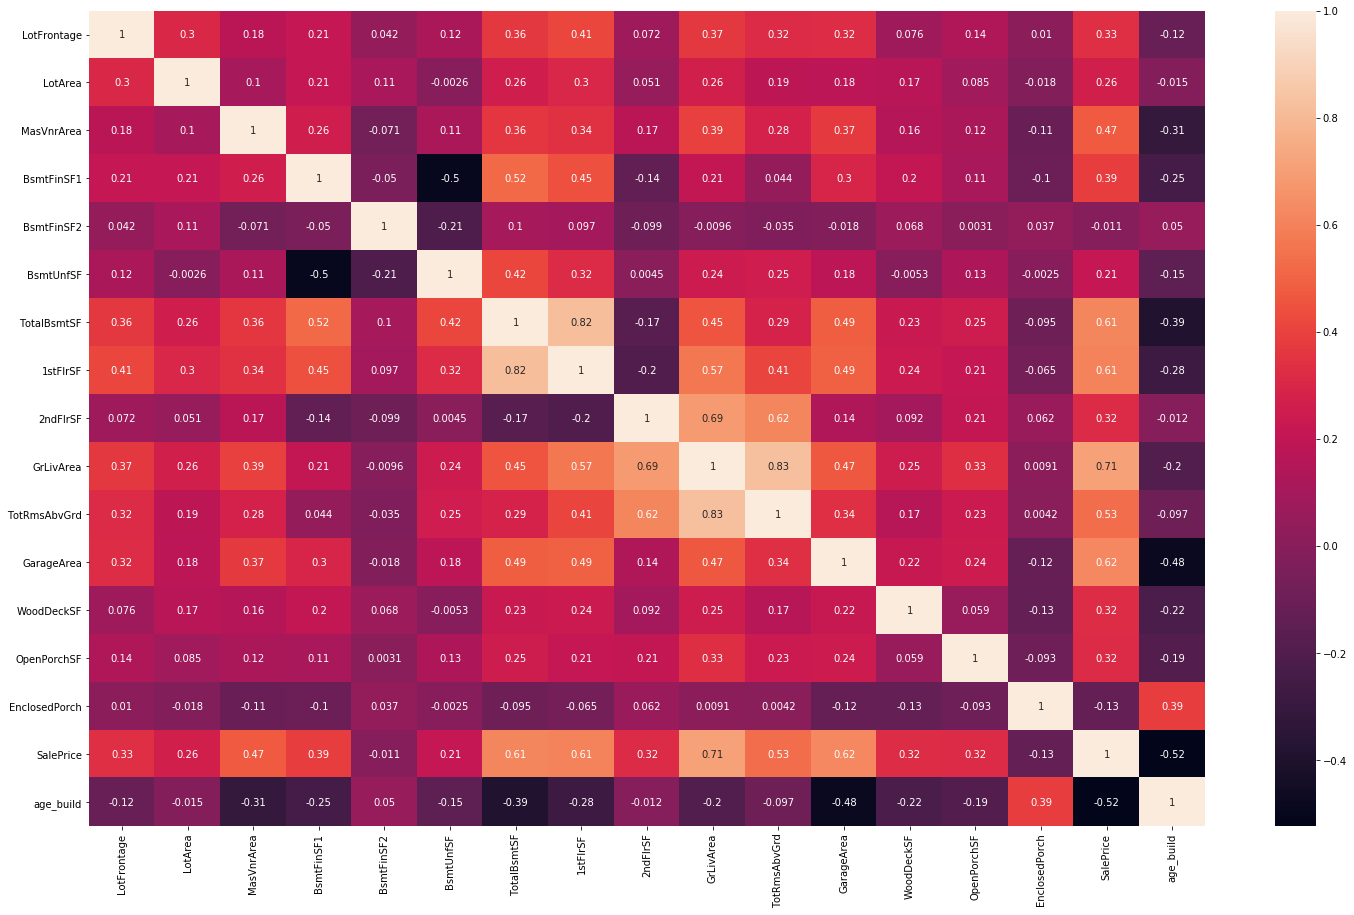

In [20]:

plt.figure(figsize=(25,15))
sns.heatmap(df.corr(),annot=True)
plt.show()

In [21]:
# Drop variables which are highly correlated

df = df.drop(['TotalBsmtSF','TotRmsAbvGrd'],axis=1)

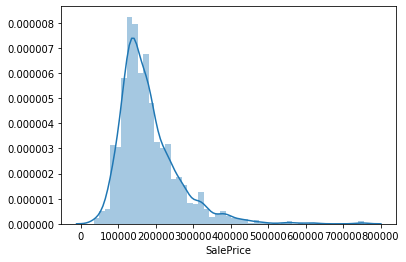

In [22]:
sns.distplot(df['SalePrice'])
plt.show()

 Sale price has outliers which will be solved in minmaxscaling.

Text(0, 0.5, 'SalePrice')

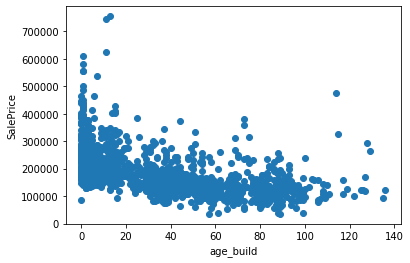

In [23]:
#scatter plot
plt.scatter(df['age_build'], df['SalePrice'])
plt.xlabel('age_build')
plt.ylabel('SalePrice')

 Sale price is higher when building age is between 1 to 20.

#### Visualising Categorical Variables:

<function matplotlib.pyplot.show(*args, **kw)>

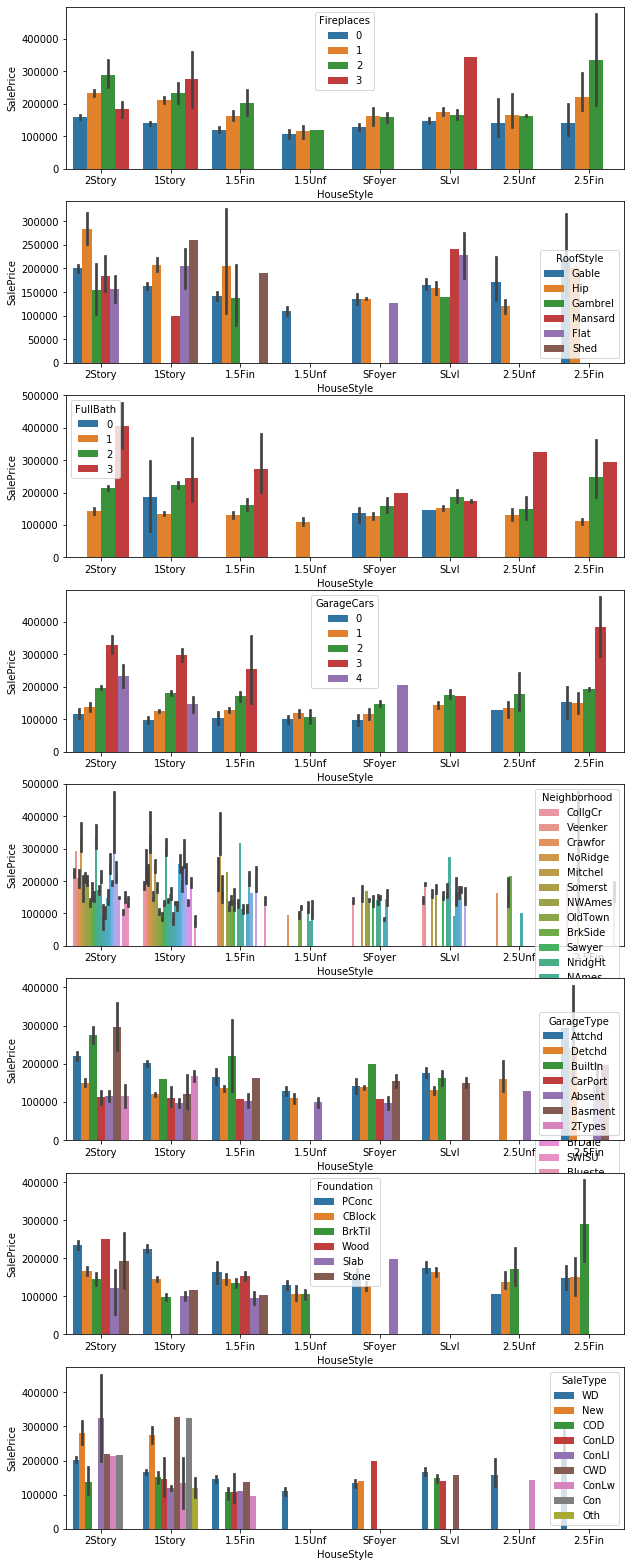

In [24]:
plt.figure(figsize=(10, 28))
plt.subplot(8,1,1)
sns.barplot(x = 'HouseStyle', y = 'SalePrice',hue='Fireplaces', data = df)

plt.subplot(8,1,2)
sns.barplot(x = 'HouseStyle', y = 'SalePrice',hue='RoofStyle', data = df)

plt.subplot(8,1,3)
sns.barplot(x = 'HouseStyle', y = 'SalePrice', hue='FullBath',data = df)

plt.subplot(8,1,4)
sns.barplot(x = 'HouseStyle', y = 'SalePrice', hue='GarageCars',data = df)

plt.subplot(8,1,5)
sns.barplot(x = 'HouseStyle', y = 'SalePrice', hue='Neighborhood',data = df)

plt.subplot(8,1,6)
sns.barplot(x = 'HouseStyle', y = 'SalePrice', hue='GarageType',data = df)

plt.subplot(8,1,7)
sns.barplot(x = 'HouseStyle', y = 'SalePrice', hue='Foundation',data = df)

plt.subplot(8,1,8)
sns.barplot(x = 'HouseStyle', y = 'SalePrice', hue='SaleType',data = df)

plt.show

From above plots it is inferred that:
    - Except 2 storey building, sale price increases with increase in the number of fire places. 
    - sale price increases with increase in the number of full bathrooms. There is a marginal decrese in split level.
    - Irrespective of the type of building , sale price is maximum when garage car capacity is 3 .

<function matplotlib.pyplot.show(*args, **kw)>

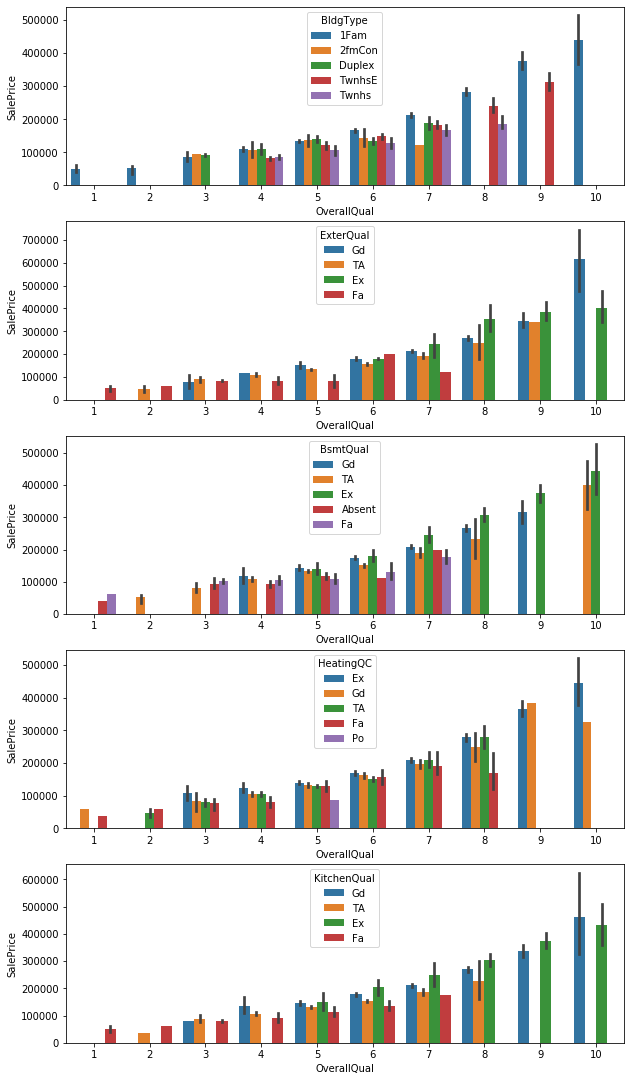

In [25]:

plt.figure(figsize = (10,23))

plt.subplot(6,1,1)
sns.barplot(x = 'OverallQual', y = 'SalePrice',hue = 'BldgType', data = df)

plt.subplot(6,1,2)
sns.barplot(x = 'OverallQual', y = 'SalePrice',hue = 'ExterQual', data = df)

plt.subplot(6,1,3)
sns.barplot(x = 'OverallQual', y = 'SalePrice',hue = 'BsmtQual', data = df)

plt.subplot(6,1,4)
sns.barplot(x = 'OverallQual', y = 'SalePrice',hue = 'HeatingQC', data = df)

plt.subplot(6,1,5)
sns.barplot(x = 'OverallQual', y = 'SalePrice',hue = 'KitchenQual', data = df)

plt.show

 From above plots it is inferred that:
        - For 1Family building type, Sale price increases with increase in overall quality .
        - Sale price is high when both kitchen quality and overall quality(9,10) are high.        

# 3: Data Preparation

### Dummy Variables:
    creating dummy variables for categorical variables

In [26]:
# subset all categorical variables
df_categorical = df.select_dtypes(include=['object'])
df_categorical.head()

,MSSubClass,MSZoning,LotShape,LandContour,LotConfig,Neighborhood,Condition1,BldgType,HouseStyle,OverallQual,...,HalfBath,BedroomAbvGr,KitchenQual,Fireplaces,FireplaceQu,GarageType,GarageFinish,GarageCars,SaleType,SaleCondition
0,60,RL,Reg,Lvl,Inside,CollgCr,Norm,1Fam,2Story,7,...,1,3,Gd,0,Absent,Attchd,RFn,2,WD,Normal
1,20,RL,Reg,Lvl,FR2,Veenker,Feedr,1Fam,1Story,6,...,0,3,TA,1,TA,Attchd,RFn,2,WD,Normal
2,60,RL,IR1,Lvl,Inside,CollgCr,Norm,1Fam,2Story,7,...,1,3,Gd,1,TA,Attchd,RFn,2,WD,Normal
3,70,RL,IR1,Lvl,Corner,Crawfor,Norm,1Fam,2Story,7,...,0,3,Gd,1,Gd,Detchd,Unf,3,WD,Abnorml
4,60,RL,IR1,Lvl,FR2,NoRidge,Norm,1Fam,2Story,8,...,1,4,Gd,1,TA,Attchd,RFn,3,WD,Normal


In [27]:
# dummies
df_dummies = pd.get_dummies(df_categorical,drop_first=True)
df_dummies.head()

,MSSubClass_30,MSSubClass_40,MSSubClass_45,MSSubClass_50,MSSubClass_60,MSSubClass_70,MSSubClass_75,MSSubClass_80,MSSubClass_85,MSSubClass_90,...,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
2,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
3,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0


In [28]:
# drop categorical variables from main dataframe
df = df.drop(list(df_categorical.columns), axis=1)

In [29]:
# concat dummy variables with df
df = pd.concat([df, df_dummies], axis=1)

In [30]:
df.shape

(1460, 228)

# 4: Splitting the Data into Training and Testing Sets

Split the main dataframe into randomly sampled train and test set . split ratio is train:test = 70% : 30%

In [31]:
# Train test split
df_train, df_test = train_test_split(df, train_size = 0.7, test_size = 0.3, random_state = 100)


## Rescaling the Features :
Variables have different scales , it affects their interpretation . To avoid this problem scaling has to be done .

Minmax scaling is used here.
minmax scaling has to be performed on numeric variables except dummy variables.

In [32]:
#create an object

scaler = MinMaxScaler()

In [33]:
# create list of numeic variables

df_numeric = df.select_dtypes(include='int64')
num_vars = df_numeric.columns
num_vars

Index(['LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'GarageArea',
       'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', 'SalePrice', 'age_build'],
      dtype='object')

In [34]:
# Scale - df_train
df_train[num_vars] = scaler.fit_transform(df_train[num_vars])
df_train.describe()

,LotFrontage,LotArea,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,1stFlrSF,2ndFlrSF,GrLivArea,GarageArea,...,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
count,1021.000000,1021.000000,1021.000000,1021.000000,1021.000000,1021.000000,1021.000000,1021.000000,1021.000000,1021.000000,...,1021.000000,1021.000000,1021.000000,1021.000000,1021.000000,1021.000000,1021.000000,1021.000000,1021.000000,1021.000000
mean,0.166249,0.042143,0.065306,0.079337,0.033980,0.241388,0.184341,0.165943,0.207345,0.332545,...,0.002938,0.003918,0.078355,0.002938,0.870715,0.002938,0.007835,0.013712,0.825661,0.078355
std,0.075615,0.048226,0.117088,0.082377,0.115907,0.192066,0.092132,0.210799,0.102232,0.150018,...,0.054153,0.062500,0.268860,0.054153,0.335680,0.054153,0.088214,0.116350,0.379587,0.268860
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.133562,0.027923,0.000000,0.000000,0.000000,0.092466,0.116435,0.000000,0.133743,0.231312,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000
50%,0.164384,0.037531,0.000000,0.069454,0.000000,0.197774,0.165278,0.000000,0.197540,0.338505,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,0.195205,0.046943,0.098750,0.126152,0.000000,0.345034,0.243056,0.352058,0.255573,0.406206,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


#### X and y split:

In [35]:
# split into X and y

y_train = df_train.pop('SalePrice')
X_train = df_train

In [36]:
X_train.shape

(1021, 227)

# 5: Building model

In this assignment automated feature selection method 'RFE 'is used along with manual fine tuning . 

- RFE - to select top performing predictors
- manual analysis - to get top predictors

### RFE
Recursive feature elimination

In [37]:
# create LinearRegression object
lm = LinearRegression()

# Fit the train model
lm.fit(X_train, y_train)

# perform RFE on top 33 features 
rfe = RFE(lm, 33)             
rfe = rfe.fit(X_train, y_train)

In [38]:
# Collect predictor variables which are selected by RFE 
col = X_train.columns[rfe.support_]
col

Index(['LotArea', '1stFlrSF', '2ndFlrSF', 'age_build', 'MSSubClass_90',
       'Neighborhood_Crawfor', 'Neighborhood_NoRidge', 'OverallQual_2',
       'OverallQual_7', 'OverallQual_8', 'OverallQual_9', 'OverallQual_10',
       'OverallCond_5', 'OverallCond_6', 'OverallCond_7', 'OverallCond_8',
       'OverallCond_9', 'Exterior1st_ImStucc', 'Exterior2nd_AsphShn',
       'Exterior2nd_CBlock', 'Exterior2nd_ImStucc', 'BsmtQual_Ex',
       'BsmtFinType1_Absent', 'FullBath_3', 'BedroomAbvGr_8', 'Fireplaces_2',
       'Fireplaces_3', 'FireplaceQu_Ex', 'GarageFinish_Fin',
       'GarageFinish_RFn', 'GarageCars_3', 'GarageCars_4', 'SaleType_Con'],
      dtype='object')

### Analysis 1 :  top 33 predictors

In [39]:
# Creating X_train_33 dataframe with RFE selected predictor variables
X_train_33 = X_train[col]
X_train_33.shape

(1021, 33)

- add constant to the dataframe 'X_train_33' to get an interceptor and create 'X_train_rfe'dataframe and build the model
- use data frame 'X_train_rfe' to perform manual analysis 

In [40]:
# add a constant to get an interceptor
X_train_rfe = sm.add_constant(X_train_33)

# Fit the resgression line using 'OLS'
lm = sm.OLS(y_train,X_train_rfe).fit() 

In [41]:
# statistical summary of MLR model
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.858
Model:                            OLS   Adj. R-squared:                  0.854
Method:                 Least Squares   F-statistic:                     181.1
Date:                Mon, 23 Nov 2020   Prob (F-statistic):               0.00
Time:                        21:19:13   Log-Likelihood:                 1804.4
No. Observations:                1021   AIC:                            -3541.
Df Residuals:                     987   BIC:                            -3373.
Df Model:                          33                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.0806      0.008      9.915      0.000       0.065       0.097
LotArea                  0.1689      0.030      5.636      0.000       0.110       0.228
1stFlrSF                 0.3360      0.021     15.697      0.000       0.294       0.378
2ndFlrSF                 0.1070      0.008     13.212      0.000       0.091       0.123
age_build               -0.1130      0.010    -11.838      0.000      -0.132      -0.094
MSSubClass_90           -0.0183      0.008     -2.387      0.017      -0.033      -0.003
Neighborhood_Crawfor     0.0433      0.008      5.391      0.000       0.028       0.059
Neighborhood_NoRidge     0.0588      0.008      7.000      0.000       0.042       0.075
OverallQual_2           -0.0221      0.030     -0.733      0.464      -0.081       0.037
OverallQual_7            0.0292      0.004      7.298      0.000       0.021       0.037
OverallQual_8            0.0673      0.006     11.737      0.000       0.056       0.079
OverallQual_9            0.1277      0.011     11.788      0.000       0.106       0.149
OverallQual_10           0.1304      0.015      8.724      0.000       0.101       0.160
OverallCond_5            0.0148      0.006      2.309      0.021       0.002       0.027
OverallCond_6            0.0297      0.007      4.451      0.000       0.017       0.043
OverallCond_7            0.0403      0.007      6.007      0.000       0.027       0.054
OverallCond_8            0.0520      0.008      6.233      0.000       0.036       0.068
OverallCond_9            0.0496      0.014      3.527      0.000       0.022       0.077
Exterior1st_ImStucc     -0.0940      0.046     -2.053      0.040      -0.184      -0.004
Exterior2nd_AsphShn     -0.0293      0.043     -0.681      0.496      -0.114       0.055
Exterior2nd_CBlock      -0.0257      0.042     -0.605      0.546      -0.109       0.058
Exterior2nd_ImStucc      0.0382      0.016      2.356      0.019       0.006       0.070
BsmtQual_Ex              0.0413      0.006      6.408      0.000       0.029       0.054
BsmtFinType1_Absent     -0.0271      0.009     -3.133      0.002      -0.044      -0.010
FullBath_3               0.0452      0.010      4.435      0.000       0.025       0.065
BedroomAbvGr_8           0.0205      0.043      0.482      0.630      -0.063       0.104
Fireplaces_2             0.0293      0.006      5.315      0.000       0.018       0.040
Fireplaces_3            -0.0908      0.020     -4.598      0.000      -0.130      -0.052
FireplaceQu_Ex           0.0303      0.010      2.966      0.003       0.010       0.050
GarageFinish_Fin         0.0195      0.004      4.501      0.000       0.011       0.028
GarageFinish_RFn         0.0166      0.004      4.186      0.000       0.009       0.024
GarageCars_3             0.0370      0.005      6.866    

#### Check VIF:
Drop 'const' before finding VIF .

In [42]:
# Drop 'const'
X_train_rfe = X_train_rfe.drop(['const'], axis=1)

# find VIF
vif = pd.DataFrame()
X = X_train_rfe
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
1,1stFlrSF,9.54
12,OverallCond_5,5.44
3,age_build,4.64
2,2ndFlrSF,2.63
28,GarageFinish_Fin,2.56
29,GarageFinish_RFn,2.44
13,OverallCond_6,2.39
14,OverallCond_7,2.38
9,OverallQual_8,2.29
0,LotArea,2.13


### Analysis 2:
    - drop'BedroomAbvGr_8' which has p-value = 0.63

In [43]:
# drop 'BedroomAbvGr_8'
X_train_rfe = X_train_rfe.drop(['BedroomAbvGr_8'], axis=1)
X_train_rfe.shape

(1021, 32)

In [44]:
#Add constant
X_train_rfe = sm.add_constant(X_train_rfe)

# Build model
lm = sm.OLS(y_train,X_train_rfe).fit()  

In [45]:
# statistical summary of MLR model
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.858
Model:                            OLS   Adj. R-squared:                  0.854
Method:                 Least Squares   F-statistic:                     186.9
Date:                Mon, 23 Nov 2020   Prob (F-statistic):               0.00
Time:                        21:19:14   Log-Likelihood:                 1804.3
No. Observations:                1021   AIC:                            -3543.
Df Residuals:                     988   BIC:                            -3380.
Df Model:                          32                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.0804      0.008      9.908      0.000       0.064       0.096
LotArea                  0.1686      0.030      5.631      0.000       0.110       0.227
1stFlrSF                 0.3370      0.021     15.832      0.000       0.295       0.379
2ndFlrSF                 0.1074      0.008     13.384      0.000       0.092       0.123
age_build               -0.1129      0.010    -11.834      0.000      -0.132      -0.094
MSSubClass_90           -0.0183      0.008     -2.400      0.017      -0.033      -0.003
Neighborhood_Crawfor     0.0432      0.008      5.381      0.000       0.027       0.059
Neighborhood_NoRidge     0.0587      0.008      6.990      0.000       0.042       0.075
OverallQual_2           -0.0219      0.030     -0.728      0.466      -0.081       0.037
OverallQual_7            0.0292      0.004      7.289      0.000       0.021       0.037
OverallQual_8            0.0672      0.006     11.733      0.000       0.056       0.078
OverallQual_9            0.1276      0.011     11.786      0.000       0.106       0.149
OverallQual_10           0.1302      0.015      8.716      0.000       0.101       0.160
OverallCond_5            0.0148      0.006      2.318      0.021       0.002       0.027
OverallCond_6            0.0297      0.007      4.456      0.000       0.017       0.043
OverallCond_7            0.0405      0.007      6.037      0.000       0.027       0.054
OverallCond_8            0.0520      0.008      6.237      0.000       0.036       0.068
OverallCond_9            0.0496      0.014      3.529      0.000       0.022       0.077
Exterior1st_ImStucc     -0.0938      0.046     -2.049      0.041      -0.184      -0.004
Exterior2nd_AsphShn     -0.0293      0.043     -0.682      0.496      -0.114       0.055
Exterior2nd_CBlock      -0.0257      0.042     -0.606      0.545      -0.109       0.058
Exterior2nd_ImStucc      0.0382      0.016      2.357      0.019       0.006       0.070
BsmtQual_Ex              0.0413      0.006      6.412      0.000       0.029       0.054
BsmtFinType1_Absent     -0.0271      0.009     -3.136      0.002      -0.044      -0.010
FullBath_3               0.0450      0.010      4.422      0.000       0.025       0.065
Fireplaces_2             0.0293      0.006      5.308      0.000       0.018       0.040
Fireplaces_3            -0.0910      0.020     -4.615      0.000      -0.130      -0.052
FireplaceQu_Ex           0.0303      0.010      2.965      0.003       0.010       0.050
GarageFinish_Fin         0.0195      0.004      4.492      0.000       0.011       0.028
GarageFinish_RFn         0.0166      0.004      4.178      0.000       0.009       0.024
GarageCars_3             0.0370      0.005      6.863      0.000       0.026       0.048
GarageCars_4             0.0435      0.019      2.269    

In [46]:
# Remove constant term
X_train_rfe = X_train_rfe.drop(['const'], axis=1)

#to find vif
vif = pd.DataFrame()
X = X_train_rfe
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
1,1stFlrSF,9.47
12,OverallCond_5,5.42
3,age_build,4.64
2,2ndFlrSF,2.59
27,GarageFinish_Fin,2.55
28,GarageFinish_RFn,2.44
13,OverallCond_6,2.39
14,OverallCond_7,2.38
9,OverallQual_8,2.29
0,LotArea,2.13


#### Analysis 3 :
    -drop 'Exterior2nd_CBlock'  which has p-value = 0.54

In [47]:
# Drop 'Exterior2nd_CBlock'
X_train_rfe = X_train_rfe.drop(['Exterior2nd_CBlock'], axis=1)
X_train_rfe.shape

(1021, 31)

In [48]:
# Add constant
X_train_rfe = sm.add_constant(X_train_rfe)

# Build model
lm = sm.OLS(y_train,X_train_rfe).fit() 

In [49]:
# statistical summary of MLR model
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.858
Model:                            OLS   Adj. R-squared:                  0.854
Method:                 Least Squares   F-statistic:                     193.1
Date:                Mon, 23 Nov 2020   Prob (F-statistic):               0.00
Time:                        21:19:14   Log-Likelihood:                 1804.1
No. Observations:                1021   AIC:                            -3544.
Df Residuals:                     989   BIC:                            -3386.
Df Model:                          31                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.0806      0.008      9.943      0.000       0.065       0.096
LotArea                  0.1689      0.030      5.644      0.000       0.110       0.228
1stFlrSF                 0.3373      0.021     15.856      0.000       0.296       0.379
2ndFlrSF                 0.1075      0.008     13.392      0.000       0.092       0.123
age_build               -0.1134      0.010    -11.935      0.000      -0.132      -0.095
MSSubClass_90           -0.0184      0.008     -2.411      0.016      -0.033      -0.003
Neighborhood_Crawfor     0.0432      0.008      5.393      0.000       0.027       0.059
Neighborhood_NoRidge     0.0587      0.008      6.995      0.000       0.042       0.075
OverallQual_2           -0.0219      0.030     -0.726      0.468      -0.081       0.037
OverallQual_7            0.0292      0.004      7.290      0.000       0.021       0.037
OverallQual_8            0.0672      0.006     11.734      0.000       0.056       0.078
OverallQual_9            0.1276      0.011     11.790      0.000       0.106       0.149
OverallQual_10           0.1302      0.015      8.717      0.000       0.101       0.159
OverallCond_5            0.0148      0.006      2.310      0.021       0.002       0.027
OverallCond_6            0.0296      0.007      4.436      0.000       0.016       0.043
OverallCond_7            0.0405      0.007      6.040      0.000       0.027       0.054
OverallCond_8            0.0521      0.008      6.243      0.000       0.036       0.068
OverallCond_9            0.0496      0.014      3.531      0.000       0.022       0.077
Exterior1st_ImStucc     -0.0938      0.046     -2.050      0.041      -0.184      -0.004
Exterior2nd_AsphShn     -0.0294      0.043     -0.683      0.495      -0.114       0.055
Exterior2nd_ImStucc      0.0381      0.016      2.354      0.019       0.006       0.070
BsmtQual_Ex              0.0413      0.006      6.413      0.000       0.029       0.054
BsmtFinType1_Absent     -0.0271      0.009     -3.133      0.002      -0.044      -0.010
FullBath_3               0.0451      0.010      4.426      0.000       0.025       0.065
Fireplaces_2             0.0293      0.006      5.314      0.000       0.018       0.040
Fireplaces_3            -0.0910      0.020     -4.615      0.000      -0.130      -0.052
FireplaceQu_Ex           0.0303      0.010      2.966      0.003       0.010       0.050
GarageFinish_Fin         0.0192      0.004      4.455      0.000       0.011       0.028
GarageFinish_RFn         0.0164      0.004      4.151      0.000       0.009       0.024
GarageCars_3             0.0370      0.005      6.864      0.000       0.026       0.048
GarageCars_4             0.0436      0.019      2.274      0.023       0.006       0.081
SaleType_Con             0.0700      0.030      2.334    

In [50]:
# Drop constant before finding vif
X_train_rfe = X_train_rfe.drop(['const'], axis=1)

# find vif
vif = pd.DataFrame()
X = X_train_rfe
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
1,1stFlrSF,9.46
12,OverallCond_5,5.42
3,age_build,4.61
2,2ndFlrSF,2.59
26,GarageFinish_Fin,2.53
27,GarageFinish_RFn,2.43
13,OverallCond_6,2.39
14,OverallCond_7,2.38
9,OverallQual_8,2.29
0,LotArea,2.13


#### Analysis 4:
    - drop 'Exterior2nd_AsphShn' which has p-value = .495

In [51]:
# drop 'Exterior2nd_AsphShn'
X_train_rfe = X_train_rfe.drop(['Exterior2nd_AsphShn'], axis=1)
X_train_rfe.shape

(1021, 30)

In [52]:
# Add constant
X_train_rfe = sm.add_constant(X_train_rfe)

# Build model
lm = sm.OLS(y_train,X_train_rfe).fit()  

In [53]:
# statistical summary of MLR model
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.858
Model:                            OLS   Adj. R-squared:                  0.854
Method:                 Least Squares   F-statistic:                     199.6
Date:                Mon, 23 Nov 2020   Prob (F-statistic):               0.00
Time:                        21:19:15   Log-Likelihood:                 1803.9
No. Observations:                1021   AIC:                            -3546.
Df Residuals:                     990   BIC:                            -3393.
Df Model:                          30                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.0808      0.008      9.989      0.000       0.065       0.097
LotArea                  0.1691      0.030      5.650      0.000       0.110       0.228
1stFlrSF                 0.3367      0.021     15.845      0.000       0.295       0.378
2ndFlrSF                 0.1075      0.008     13.394      0.000       0.092       0.123
age_build               -0.1135      0.010    -11.944      0.000      -0.132      -0.095
MSSubClass_90           -0.0189      0.008     -2.477      0.013      -0.034      -0.004
Neighborhood_Crawfor     0.0433      0.008      5.398      0.000       0.028       0.059
Neighborhood_NoRidge     0.0587      0.008      6.997      0.000       0.042       0.075
OverallQual_2           -0.0220      0.030     -0.731      0.465      -0.081       0.037
OverallQual_7            0.0292      0.004      7.293      0.000       0.021       0.037
OverallQual_8            0.0672      0.006     11.741      0.000       0.056       0.078
OverallQual_9            0.1276      0.011     11.795      0.000       0.106       0.149
OverallQual_10           0.1302      0.015      8.724      0.000       0.101       0.160
OverallCond_5            0.0146      0.006      2.284      0.023       0.002       0.027
OverallCond_6            0.0294      0.007      4.417      0.000       0.016       0.042
OverallCond_7            0.0404      0.007      6.023      0.000       0.027       0.054
OverallCond_8            0.0519      0.008      6.227      0.000       0.036       0.068
OverallCond_9            0.0494      0.014      3.519      0.000       0.022       0.077
Exterior1st_ImStucc     -0.0939      0.046     -2.051      0.041      -0.184      -0.004
Exterior2nd_ImStucc      0.0382      0.016      2.357      0.019       0.006       0.070
BsmtQual_Ex              0.0413      0.006      6.416      0.000       0.029       0.054
BsmtFinType1_Absent     -0.0279      0.009     -3.263      0.001      -0.045      -0.011
FullBath_3               0.0451      0.010      4.434      0.000       0.025       0.065
Fireplaces_2             0.0293      0.006      5.322      0.000       0.019       0.040
Fireplaces_3            -0.0909      0.020     -4.611      0.000      -0.130      -0.052
FireplaceQu_Ex           0.0303      0.010      2.970      0.003       0.010       0.050
GarageFinish_Fin         0.0192      0.004      4.461      0.000       0.011       0.028
GarageFinish_RFn         0.0165      0.004      4.160      0.000       0.009       0.024
GarageCars_3             0.0370      0.005      6.868      0.000       0.026       0.048
GarageCars_4             0.0437      0.019      2.284      0.023       0.006       0.081
SaleType_Con             0.0700      0.030      2.335      0.020       0.011       0.129
=========================================================

In [54]:
# Drop constant before finding vif
X_train_rfe = X_train_rfe.drop(['const'], axis=1)

# find vif
vif = pd.DataFrame()
X = X_train_rfe
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
1,1stFlrSF,9.45
12,OverallCond_5,5.42
3,age_build,4.61
2,2ndFlrSF,2.59
25,GarageFinish_Fin,2.53
26,GarageFinish_RFn,2.43
13,OverallCond_6,2.39
14,OverallCond_7,2.38
9,OverallQual_8,2.29
0,LotArea,2.13


#### Analysis 5:
    - drop 'OverallQual_2' which had p-value = 0.465

In [55]:
# drop 'OverallQual_2'
X_train_rfe = X_train_rfe.drop(['OverallQual_2'], axis=1)
X_train_rfe.shape

(1021, 29)

In [56]:
# Add constant
X_train_rfe = sm.add_constant(X_train_rfe)

# Build model
lm = sm.OLS(y_train,X_train_rfe).fit()  

In [57]:
# statistical summary of MLR model
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.858
Model:                            OLS   Adj. R-squared:                  0.854
Method:                 Least Squares   F-statistic:                     206.6
Date:                Mon, 23 Nov 2020   Prob (F-statistic):               0.00
Time:                        21:19:16   Log-Likelihood:                 1803.6
No. Observations:                1021   AIC:                            -3547.
Df Residuals:                     991   BIC:                            -3399.
Df Model:                          29                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.0803      0.008      9.967      0.000       0.064       0.096
LotArea                  0.1686      0.030      5.637      0.000       0.110       0.227
1stFlrSF                 0.3383      0.021     16.008      0.000       0.297       0.380
2ndFlrSF                 0.1079      0.008     13.495      0.000       0.092       0.124
age_build               -0.1138      0.009    -12.000      0.000      -0.132      -0.095
MSSubClass_90           -0.0189      0.008     -2.479      0.013      -0.034      -0.004
Neighborhood_Crawfor     0.0432      0.008      5.396      0.000       0.028       0.059
Neighborhood_NoRidge     0.0586      0.008      6.983      0.000       0.042       0.075
OverallQual_7            0.0291      0.004      7.280      0.000       0.021       0.037
OverallQual_8            0.0671      0.006     11.728      0.000       0.056       0.078
OverallQual_9            0.1275      0.011     11.787      0.000       0.106       0.149
OverallQual_10           0.1299      0.015      8.707      0.000       0.101       0.159
OverallCond_5            0.0149      0.006      2.332      0.020       0.002       0.027
OverallCond_6            0.0298      0.007      4.494      0.000       0.017       0.043
OverallCond_7            0.0408      0.007      6.108      0.000       0.028       0.054
OverallCond_8            0.0524      0.008      6.300      0.000       0.036       0.069
OverallCond_9            0.0499      0.014      3.555      0.000       0.022       0.077
Exterior1st_ImStucc     -0.0938      0.046     -2.049      0.041      -0.184      -0.004
Exterior2nd_ImStucc      0.0382      0.016      2.362      0.018       0.006       0.070
BsmtQual_Ex              0.0412      0.006      6.412      0.000       0.029       0.054
BsmtFinType1_Absent     -0.0278      0.009     -3.250      0.001      -0.045      -0.011
FullBath_3               0.0450      0.010      4.418      0.000       0.025       0.065
Fireplaces_2             0.0293      0.006      5.321      0.000       0.018       0.040
Fireplaces_3            -0.0912      0.020     -4.629      0.000      -0.130      -0.053
FireplaceQu_Ex           0.0303      0.010      2.972      0.003       0.010       0.050
GarageFinish_Fin         0.0192      0.004      4.454      0.000       0.011       0.028
GarageFinish_RFn         0.0164      0.004      4.156      0.000       0.009       0.024
GarageCars_3             0.0370      0.005      6.865      0.000       0.026       0.048
GarageCars_4             0.0438      0.019      2.287      0.022       0.006       0.081
SaleType_Con             0.0701      0.030      2.336      0.020       0.011       0.129
==============================================================================
Omnibus:                      651.848   Durbin-Watson:             

In [58]:
# Drop constant before finding vif
X_train_rfe = X_train_rfe.drop(['const'], axis=1)

# find vif
vif = pd.DataFrame()
X = X_train_rfe
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
1,1stFlrSF,9.40
11,OverallCond_5,5.42
3,age_build,4.54
2,2ndFlrSF,2.58
24,GarageFinish_Fin,2.52
25,GarageFinish_RFn,2.43
12,OverallCond_6,2.39
13,OverallCond_7,2.38
8,OverallQual_8,2.28
0,LotArea,2.12


#### Analysis 6:
    -drop '1stFlrSF' which has VIF = 9.40

In [59]:
# drop '1stFlrSF'
X_train_rfe = X_train_rfe.drop(['1stFlrSF'], axis=1)
X_train_rfe.shape

(1021, 28)

In [60]:
# Add constant
X_train_rfe = sm.add_constant(X_train_rfe)

# Build model
lm = sm.OLS(y_train,X_train_rfe).fit()  

In [61]:
# statistical summary of MLR model
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.821
Model:                            OLS   Adj. R-squared:                  0.816
Method:                 Least Squares   F-statistic:                     162.9
Date:                Mon, 23 Nov 2020   Prob (F-statistic):               0.00
Time:                        21:19:16   Log-Likelihood:                 1686.2
No. Observations:                1021   AIC:                            -3314.
Df Residuals:                     992   BIC:                            -3171.
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.1293      0.008     15.472      0.000       0.113       0.146
LotArea                  0.2881      0.032      8.870      0.000       0.224       0.352
2ndFlrSF                 0.0500      0.008      6.253      0.000       0.034       0.066
age_build               -0.1055      0.011     -9.932      0.000      -0.126      -0.085
MSSubClass_90            0.0088      0.008      1.061      0.289      -0.007       0.025
Neighborhood_Crawfor     0.0570      0.009      6.377      0.000       0.039       0.074
Neighborhood_NoRidge     0.0778      0.009      8.359      0.000       0.060       0.096
OverallQual_7            0.0411      0.004      9.340      0.000       0.032       0.050
OverallQual_8            0.0921      0.006     14.915      0.000       0.080       0.104
OverallQual_9            0.1567      0.012     13.107      0.000       0.133       0.180
OverallQual_10           0.1962      0.016     12.213      0.000       0.165       0.228
OverallCond_5            0.0102      0.007      1.424      0.155      -0.004       0.024
OverallCond_6            0.0266      0.007      3.582      0.000       0.012       0.041
OverallCond_7            0.0379      0.007      5.064      0.000       0.023       0.053
OverallCond_8            0.0454      0.009      4.883      0.000       0.027       0.064
OverallCond_9            0.0431      0.016      2.745      0.006       0.012       0.074
Exterior1st_ImStucc     -0.1164      0.051     -2.269      0.023      -0.217      -0.016
Exterior2nd_ImStucc      0.0420      0.018      2.312      0.021       0.006       0.078
BsmtQual_Ex              0.0493      0.007      6.862      0.000       0.035       0.063
BsmtFinType1_Absent     -0.0310      0.010     -3.235      0.001      -0.050      -0.012
FullBath_3               0.0666      0.011      5.892      0.000       0.044       0.089
Fireplaces_2             0.0391      0.006      6.366      0.000       0.027       0.051
Fireplaces_3            -0.0244      0.022     -1.132      0.258      -0.067       0.018
FireplaceQu_Ex           0.0322      0.011      2.812      0.005       0.010       0.055
GarageFinish_Fin         0.0325      0.005      6.856      0.000       0.023       0.042
GarageFinish_RFn         0.0302      0.004      6.982      0.000       0.022       0.039
GarageCars_3             0.0448      0.006      7.443      0.000       0.033       0.057
GarageCars_4             0.0539      0.021      2.514      0.012       0.012       0.096
SaleType_Con             0.0697      0.034      2.073      0.038       0.004       0.136
==============================================================================
Omnibus:                      215.809   Durbin-Watson:                   1.958
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4681.25

In [62]:
# Drop constant before finding vif
X_train_rfe = X_train_rfe.drop(['const'], axis=1)

# find vif
vif = pd.DataFrame()
X = X_train_rfe
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
10,OverallCond_5,4.46
2,age_build,4.05
23,GarageFinish_Fin,2.30
24,GarageFinish_RFn,2.18
12,OverallCond_7,2.18
11,OverallCond_6,2.15
1,2ndFlrSF,2.12
7,OverallQual_8,2.09
17,BsmtQual_Ex,2.03
25,GarageCars_3,1.99


#### Analysis 7:
    -drop 'MSSubClass_90' which has p-value = 0.289

In [63]:
# drop 'MSSubClass_90'
X_train_rfe = X_train_rfe.drop(['MSSubClass_90'], axis=1)
X_train_rfe.shape

(1021, 27)

In [64]:
# Add constant
X_train_rfe = sm.add_constant(X_train_rfe)

# Build model
lm = sm.OLS(y_train,X_train_rfe).fit()  

In [65]:
# statistical summary of MLR model
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.821
Model:                            OLS   Adj. R-squared:                  0.816
Method:                 Least Squares   F-statistic:                     168.9
Date:                Mon, 23 Nov 2020   Prob (F-statistic):               0.00
Time:                        21:19:17   Log-Likelihood:                 1685.6
No. Observations:                1021   AIC:                            -3315.
Df Residuals:                     993   BIC:                            -3177.
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.1307      0.008     15.840      0.000       0.114       0.147
LotArea                  0.2887      0.032      8.892      0.000       0.225       0.352
2ndFlrSF                 0.0501      0.008      6.259      0.000       0.034       0.066
age_build               -0.1065      0.011    -10.066      0.000      -0.127      -0.086
Neighborhood_Crawfor     0.0572      0.009      6.412      0.000       0.040       0.075
Neighborhood_NoRidge     0.0778      0.009      8.361      0.000       0.060       0.096
OverallQual_7            0.0407      0.004      9.280      0.000       0.032       0.049
OverallQual_8            0.0916      0.006     14.877      0.000       0.079       0.104
OverallQual_9            0.1562      0.012     13.076      0.000       0.133       0.180
OverallQual_10           0.1957      0.016     12.185      0.000       0.164       0.227
OverallCond_5            0.0100      0.007      1.395      0.163      -0.004       0.024
OverallCond_6            0.0260      0.007      3.502      0.000       0.011       0.040
OverallCond_7            0.0371      0.007      4.983      0.000       0.022       0.052
OverallCond_8            0.0447      0.009      4.817      0.000       0.026       0.063
OverallCond_9            0.0425      0.016      2.708      0.007       0.012       0.073
Exterior1st_ImStucc     -0.1170      0.051     -2.282      0.023      -0.218      -0.016
Exterior2nd_ImStucc      0.0426      0.018      2.347      0.019       0.007       0.078
BsmtQual_Ex              0.0492      0.007      6.845      0.000       0.035       0.063
BsmtFinType1_Absent     -0.0277      0.009     -3.056      0.002      -0.045      -0.010
FullBath_3               0.0670      0.011      5.923      0.000       0.045       0.089
Fireplaces_2             0.0391      0.006      6.367      0.000       0.027       0.051
Fireplaces_3            -0.0243      0.022     -1.124      0.261      -0.067       0.018
FireplaceQu_Ex           0.0320      0.011      2.797      0.005       0.010       0.054
GarageFinish_Fin         0.0318      0.005      6.774      0.000       0.023       0.041
GarageFinish_RFn         0.0296      0.004      6.900      0.000       0.021       0.038
GarageCars_3             0.0448      0.006      7.450      0.000       0.033       0.057
GarageCars_4             0.0571      0.021      2.690      0.007       0.015       0.099
SaleType_Con             0.0693      0.034      2.062      0.039       0.003       0.135
==============================================================================
Omnibus:                      216.539   Durbin-Watson:                   1.956
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4674.877
Skew:                          -0.366   Prob(JB):                         0.00
Kurtosis

In [66]:
# Drop constant before finding vif
X_train_rfe = X_train_rfe.drop(['const'], axis=1)

# find vif
vif = pd.DataFrame()
X = X_train_rfe
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
9,OverallCond_5,4.31
2,age_build,4.05
22,GarageFinish_Fin,2.28
11,OverallCond_7,2.18
23,GarageFinish_RFn,2.16
10,OverallCond_6,2.15
1,2ndFlrSF,2.12
6,OverallQual_8,2.08
16,BsmtQual_Ex,2.03
24,GarageCars_3,1.99


#### Analysis 8:
    - drop 'Fireplaces_3' which has p-value =0.261

In [67]:
# drop 'Fireplaces_3'
X_train_rfe = X_train_rfe.drop(['Fireplaces_3'], axis=1)
X_train_rfe.shape

(1021, 26)

In [68]:
# Add constant
X_train_rfe = sm.add_constant(X_train_rfe)

# Build model
lm = sm.OLS(y_train,X_train_rfe).fit()  

In [69]:
# statistical summary of MLR model
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.821
Model:                            OLS   Adj. R-squared:                  0.816
Method:                 Least Squares   F-statistic:                     175.3
Date:                Mon, 23 Nov 2020   Prob (F-statistic):               0.00
Time:                        21:19:17   Log-Likelihood:                 1684.9
No. Observations:                1021   AIC:                            -3316.
Df Residuals:                     994   BIC:                            -3183.
Df Model:                          26                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.1309      0.008     15.874      0.000       0.115       0.147
LotArea                  0.2858      0.032      8.829      0.000       0.222       0.349
2ndFlrSF                 0.0499      0.008      6.237      0.000       0.034       0.066
age_build               -0.1067      0.011    -10.088      0.000      -0.127      -0.086
Neighborhood_Crawfor     0.0573      0.009      6.423      0.000       0.040       0.075
Neighborhood_NoRidge     0.0783      0.009      8.417      0.000       0.060       0.097
OverallQual_7            0.0405      0.004      9.247      0.000       0.032       0.049
OverallQual_8            0.0911      0.006     14.833      0.000       0.079       0.103
OverallQual_9            0.1551      0.012     13.026      0.000       0.132       0.178
OverallQual_10           0.1935      0.016     12.136      0.000       0.162       0.225
OverallCond_5            0.0099      0.007      1.389      0.165      -0.004       0.024
OverallCond_6            0.0258      0.007      3.480      0.001       0.011       0.040
OverallCond_7            0.0369      0.007      4.959      0.000       0.022       0.052
OverallCond_8            0.0447      0.009      4.815      0.000       0.026       0.063
OverallCond_9            0.0426      0.016      2.711      0.007       0.012       0.073
Exterior1st_ImStucc     -0.1175      0.051     -2.292      0.022      -0.218      -0.017
Exterior2nd_ImStucc      0.0425      0.018      2.344      0.019       0.007       0.078
BsmtQual_Ex              0.0492      0.007      6.849      0.000       0.035       0.063
BsmtFinType1_Absent     -0.0277      0.009     -3.053      0.002      -0.045      -0.010
FullBath_3               0.0677      0.011      5.995      0.000       0.046       0.090
Fireplaces_2             0.0395      0.006      6.446      0.000       0.027       0.052
FireplaceQu_Ex           0.0314      0.011      2.745      0.006       0.009       0.054
GarageFinish_Fin         0.0316      0.005      6.732      0.000       0.022       0.041
GarageFinish_RFn         0.0296      0.004      6.916      0.000       0.021       0.038
GarageCars_3             0.0452      0.006      7.539      0.000       0.033       0.057
GarageCars_4             0.0574      0.021      2.702      0.007       0.016       0.099
SaleType_Con             0.0695      0.034      2.067      0.039       0.004       0.136
==============================================================================
Omnibus:                      229.936   Durbin-Watson:                   1.956
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5146.887
Skew:                          -0.435   Prob(JB):                         0.00
Kurtosis:                      13.965   Cond. No.                         47.0
==================

In [70]:
# Drop constant before finding vif
X_train_rfe = X_train_rfe.drop(['const'], axis=1)

# find vif
vif = pd.DataFrame()
X = X_train_rfe
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
9,OverallCond_5,4.31
2,age_build,4.05
21,GarageFinish_Fin,2.28
11,OverallCond_7,2.18
22,GarageFinish_RFn,2.16
10,OverallCond_6,2.15
1,2ndFlrSF,2.12
6,OverallQual_8,2.07
16,BsmtQual_Ex,2.03
23,GarageCars_3,1.98


#### Anaysis 9:
    - drop OverallCond_5 which has p-value = 0.165

In [71]:
# drop OverallCond_5
X_train_rfe = X_train_rfe.drop(['OverallCond_5'], axis=1)
X_train_rfe.shape

(1021, 25)

In [72]:
# Add constant
X_train_rfe = sm.add_constant(X_train_rfe)

# Build model
lm = sm.OLS(y_train,X_train_rfe).fit()  

In [73]:
# statistical summary of MLR model
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.821
Model:                            OLS   Adj. R-squared:                  0.816
Method:                 Least Squares   F-statistic:                     182.0
Date:                Mon, 23 Nov 2020   Prob (F-statistic):               0.00
Time:                        21:19:18   Log-Likelihood:                 1684.0
No. Observations:                1021   AIC:                            -3316.
Df Residuals:                     995   BIC:                            -3188.
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.1404      0.005     29.981      0.000       0.131       0.150
LotArea                  0.2857      0.032      8.821      0.000       0.222       0.349
2ndFlrSF                 0.0506      0.008      6.331      0.000       0.035       0.066
age_build               -0.1104      0.010    -10.780      0.000      -0.131      -0.090
Neighborhood_Crawfor     0.0579      0.009      6.488      0.000       0.040       0.075
Neighborhood_NoRidge     0.0782      0.009      8.409      0.000       0.060       0.096
OverallQual_7            0.0409      0.004      9.353      0.000       0.032       0.049
OverallQual_8            0.0915      0.006     14.902      0.000       0.079       0.104
OverallQual_9            0.1553      0.012     13.043      0.000       0.132       0.179
OverallQual_10           0.1941      0.016     12.169      0.000       0.163       0.225
OverallCond_6            0.0176      0.004      3.940      0.000       0.009       0.026
OverallCond_7            0.0289      0.005      6.155      0.000       0.020       0.038
OverallCond_8            0.0368      0.007      5.010      0.000       0.022       0.051
OverallCond_9            0.0348      0.015      2.369      0.018       0.006       0.064
Exterior1st_ImStucc     -0.1163      0.051     -2.267      0.024      -0.217      -0.016
Exterior2nd_ImStucc      0.0419      0.018      2.309      0.021       0.006       0.078
BsmtQual_Ex              0.0494      0.007      6.876      0.000       0.035       0.064
BsmtFinType1_Absent     -0.0283      0.009     -3.130      0.002      -0.046      -0.011
FullBath_3               0.0675      0.011      5.975      0.000       0.045       0.090
Fireplaces_2             0.0395      0.006      6.450      0.000       0.028       0.052
FireplaceQu_Ex           0.0305      0.011      2.674      0.008       0.008       0.053
GarageFinish_Fin         0.0316      0.005      6.734      0.000       0.022       0.041
GarageFinish_RFn         0.0297      0.004      6.930      0.000       0.021       0.038
GarageCars_3             0.0451      0.006      7.511      0.000       0.033       0.057
GarageCars_4             0.0566      0.021      2.665      0.008       0.015       0.098
SaleType_Con             0.0697      0.034      2.071      0.039       0.004       0.136
==============================================================================
Omnibus:                      231.159   Durbin-Watson:                   1.963
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5135.879
Skew:                          -0.446   Prob(JB):                         0.00
Kurtosis:                      13.951   Cond. No.                         41.7
==============================================================================

Warnings:
[1] Standard Erro

In [74]:
# Drop constant before finding vif
X_train_rfe = X_train_rfe.drop(['const'], axis=1)

# find vif
vif = pd.DataFrame()
X = X_train_rfe
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
2,age_build,2.92
1,2ndFlrSF,2.09
15,BsmtQual_Ex,2.01
22,GarageCars_3,1.98
6,OverallQual_8,1.97
0,LotArea,1.91
20,GarageFinish_Fin,1.84
5,OverallQual_7,1.74
21,GarageFinish_RFn,1.71
7,OverallQual_9,1.70


From above analysis of train set has top 25 predictors.
    -for all predictor variables p <0.05 and vif < 5
 

In [75]:
 X.columns

Index(['LotArea', '2ndFlrSF', 'age_build', 'Neighborhood_Crawfor',
       'Neighborhood_NoRidge', 'OverallQual_7', 'OverallQual_8',
       'OverallQual_9', 'OverallQual_10', 'OverallCond_6', 'OverallCond_7',
       'OverallCond_8', 'OverallCond_9', 'Exterior1st_ImStucc',
       'Exterior2nd_ImStucc', 'BsmtQual_Ex', 'BsmtFinType1_Absent',
       'FullBath_3', 'Fireplaces_2', 'FireplaceQu_Ex', 'GarageFinish_Fin',
       'GarageFinish_RFn', 'GarageCars_3', 'GarageCars_4', 'SaleType_Con'],
      dtype='object')

####  Residual Analysis of the train data

- check on error terms (residuals)
    - nomally distribution - distplot
    - constant variance - scatter plot

In [76]:
# create new df and add contant term

X_train_lm = sm.add_constant(X_train_rfe)

In [77]:
# predit y_train_cnt
y_train_cnt = lm.predict(X_train_lm)

<function matplotlib.pyplot.show(*args, **kw)>

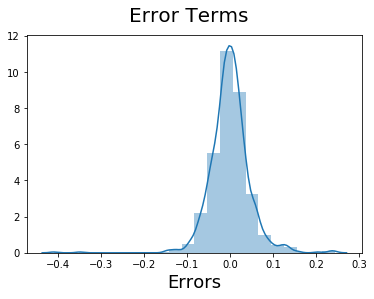

In [78]:
# Plot the histogram of the error terms
fig = plt.figure()
sns.distplot((y_train - y_train_cnt), bins = 22)
fig.suptitle('Error Terms', fontsize = 20)                  
plt.xlabel('Errors', fontsize = 18)                         
plt.show

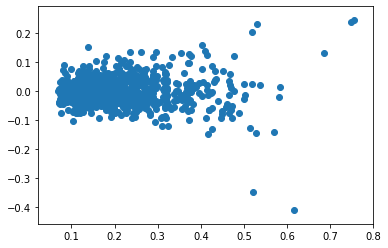

In [79]:
# Scatterplot on error terms
# res = difference between y valus and predicted y value
res = (y_train - y_train_cnt)

plt.scatter(y_train_cnt,res)

# 6: Making Predictions on Test set

     Now that the model is ready . perform analysis on test set.
         - scale the predictor variables that are scaled in train set

In [80]:
# perform scaling - transform()

df_test[num_vars] = scaler.transform(df_test[num_vars])

In [81]:
# create X_test,y_test data frames
y_test = df_test.pop('SalePrice')
X_test = df_test

In [82]:
# Creating X_test_rfe dataframe by dropping variables from X_test
X_test_rfe = X_test[X_train_rfe.columns]

# Adding a constant variable and create X_test_new 
X_test_new = sm.add_constant(X_test_rfe)

In [83]:
# Making predictions
y_pred = lm.predict(X_test_new)

# 7: Model Evaluation

- Plot actual y_test vs predicted y.
- Find r2 value of test set

Text(0, 0.5, 'y_pred')

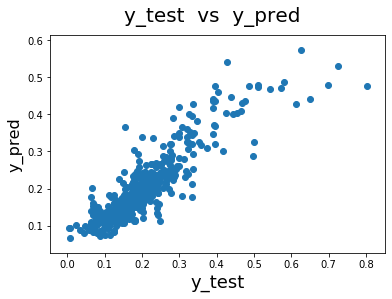

In [84]:
# Plotting y_test and y_pred to understand the spread.
fig = plt.figure()
plt.scatter(y_test,y_pred)
fig.suptitle('y_test  vs  y_pred', fontsize=20)              # Plot heading 
plt.xlabel('y_test', fontsize=18)                          # X-label
plt.ylabel('y_pred', fontsize=16)                          # Y-label

In [85]:
# compare r2 score of train and test set

print ( 'r2 score of train set = ', r2_score(y_true = y_train, y_pred=y_train_cnt) )
print ( 'r2 score of test set = ', r2_score(y_true = y_test, y_pred=y_pred) )

r2 score of train set =  0.8205711480466941
r2 score of test set =  0.7843383142139319


# 8. Model Building and Evaluation
Ridge and Lasso Regression¶

Let's now try predicting house prices, using ridge and lasso regression.



# Ridge Regression

In [86]:
# list of alphas to tune
params = {'alpha': [ 0.0001,0.001, 0.01, 0.05, 0.1,
 0.2,  0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0,2,3,4,5,6,7,8,9,10]}



ridge = Ridge()

# cross validation
folds = 5
model_cv = GridSearchCV(estimator = ridge, 
                        param_grid = params, 
                        scoring= 'neg_mean_absolute_error', 
                        cv = folds, 
                        return_train_score=True,
                        verbose = 1)            
model_cv.fit(X_train_rfe, y_train)  # X_train_rfe -> has top 25 predictors after RFE

Fitting 5 folds for each of 23 candidates, totalling 115 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 115 out of 115 | elapsed:    2.4s finished


GridSearchCV(cv=5, estimator=Ridge(),
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3,
                                   0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2, 3, 4,
                                   5, 6, 7, 8, 9, 10]},
             return_train_score=True, scoring='neg_mean_absolute_error',
             verbose=1)

In [87]:
cv_results_R = pd.DataFrame(model_cv.cv_results_)
#cv_results = cv_results[cv_results['param_alpha']<=200]
cv_results_R.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.078618,0.138281,0.004800,0.001326,0.0001,{'alpha': 0.0001},-0.032186,-0.035477,-0.037468,-0.030210,...,-0.033592,0.002566,1,-0.032507,-0.030810,-0.031137,-0.032882,-0.032442,-0.031956,0.000822
1,0.009396,0.001200,0.005395,0.001201,0.001,{'alpha': 0.001},-0.032187,-0.035477,-0.037468,-0.030211,...,-0.033593,0.002566,2,-0.032507,-0.030811,-0.031138,-0.032883,-0.032443,-0.031956,0.000822
2,0.006596,0.002869,0.004625,0.002852,0.01,{'alpha': 0.01},-0.032195,-0.035469,-0.037471,-0.030216,...,-0.033597,0.002563,3,-0.032511,-0.030817,-0.031142,-0.032888,-0.032452,-0.031962,0.000823
3,0.004789,0.001593,0.002598,0.000800,0.05,{'alpha': 0.05},-0.032229,-0.035437,-0.037484,-0.030238,...,-0.033618,0.002547,4,-0.032526,-0.030846,-0.031159,-0.032918,-0.032489,-0.031987,0.000824
4,0.006197,0.001469,0.002799,0.000980,0.1,{'alpha': 0.1},-0.032273,-0.035407,-0.037498,-0.030264,...,-0.033644,0.002531,5,-0.032552,-0.030885,-0.031181,-0.032958,-0.032537,-0.032023,0.000827


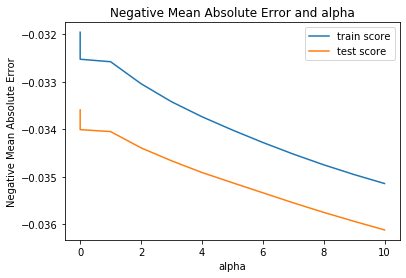

In [88]:
# plotting mean test and train scoes with alpha 
cv_results_R['param_alpha'] = cv_results_R['param_alpha'].astype('int32')

# plotting
plt.plot(cv_results_R['param_alpha'], cv_results_R['mean_train_score'])
plt.plot(cv_results_R['param_alpha'], cv_results_R['mean_test_score'])
plt.xlabel('alpha')
plt.ylabel('Negative Mean Absolute Error')

plt.title("Negative Mean Absolute Error and alpha")
plt.legend(['train score', 'test score'], loc='right left')
plt.show()

In [89]:
alpha = 0.5
ridge = Ridge(alpha=alpha)

ridge.fit(X_train_rfe, y_train)
# predict
y_train_pred = ridge.predict(X_train_rfe)
print(metrics.r2_score(y_true=y_train, y_pred=y_train_pred))
y_test_pred = ridge.predict(X_test_rfe)
print(metrics.r2_score(y_true=y_test, y_pred=y_test_pred))

0.8197584115548342
0.7816103714653655


In [90]:
# Ridge model parameters
model_parameters_R = list(ridge.coef_)
model_parameters_R.insert(0, ridge.intercept_)
model_parameters_R = [round(x, 3) for x in model_parameters_R]
cols = X_train_rfe.columns
cols = cols.insert(0, "constant")
lis_coeff=list(zip(cols, model_parameters_R))
sorted(lis_coeff, key=lambda x: x[1], reverse=True)

[('LotArea', 0.232),
 ('OverallQual_10', 0.185),
 ('OverallQual_9', 0.149),
 ('constant', 0.142),
 ('OverallQual_8', 0.089),
 ('Neighborhood_NoRidge', 0.077),
 ('FullBath_3', 0.069),
 ('Neighborhood_Crawfor', 0.056),
 ('SaleType_Con', 0.055),
 ('BsmtQual_Ex', 0.052),
 ('GarageCars_4', 0.052),
 ('2ndFlrSF', 0.051),
 ('GarageCars_3', 0.047),
 ('Fireplaces_2', 0.043),
 ('OverallQual_7', 0.04),
 ('OverallCond_8', 0.035),
 ('Exterior2nd_ImStucc', 0.034),
 ('GarageFinish_Fin', 0.033),
 ('OverallCond_9', 0.032),
 ('FireplaceQu_Ex', 0.032),
 ('GarageFinish_RFn', 0.03),
 ('OverallCond_7', 0.028),
 ('OverallCond_6', 0.017),
 ('BsmtFinType1_Absent', -0.029),
 ('Exterior1st_ImStucc', -0.071),
 ('age_build', -0.108)]

# Lasso

In [91]:
# list of alphas to tune
params = {'alpha': [ 0.00005,0.0001,0.0005,0.001, 0.01,  0.1, 
 0.2,0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0 ]}
lasso = Lasso()

# cross validation
model_cv = GridSearchCV(estimator = lasso, 
                        param_grid = params, 
                        scoring= 'neg_mean_absolute_error', 
                        cv = folds, 
                        return_train_score=True,
                        verbose = 1)            

model_cv.fit(X_train_rfe, y_train) 

Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  75 out of  75 | elapsed:    1.1s finished


GridSearchCV(cv=5, estimator=Lasso(),
             param_grid={'alpha': [5e-05, 0.0001, 0.0005, 0.001, 0.01, 0.1, 0.2,
                                   0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]},
             return_train_score=True, scoring='neg_mean_absolute_error',
             verbose=1)

In [92]:
cv_results = pd.DataFrame(model_cv.cv_results_)

cv_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.045564,0.075213,0.004597,0.003380,5e-05,{'alpha': 5e-05},-0.032258,-0.035424,-0.037286,-0.030390,...,-0.033617,0.002441,1,-0.032519,-0.030888,-0.031169,-0.032978,-0.032632,-0.032037,0.000842
1,0.005592,0.001618,0.004398,0.001854,0.0001,{'alpha': 0.0001},-0.032372,-0.035420,-0.037325,-0.030510,...,-0.033764,0.002378,2,-0.032602,-0.031028,-0.031367,-0.033109,-0.032882,-0.032198,0.000839
2,0.005801,0.001475,0.002395,0.000792,0.0005,{'alpha': 0.0005},-0.033924,-0.036564,-0.037887,-0.032884,...,-0.035469,0.001816,3,-0.034326,-0.033055,-0.033109,-0.035019,-0.035010,-0.034104,0.000872
3,0.006594,0.002335,0.004206,0.000985,0.001,{'alpha': 0.001},-0.035431,-0.039075,-0.038788,-0.035229,...,-0.037378,0.001688,4,-0.036883,-0.035731,-0.035512,-0.037165,-0.036645,-0.036387,0.000650
4,0.005588,0.001350,0.003198,0.001165,0.01,{'alpha': 0.01},-0.061846,-0.066601,-0.061168,-0.058372,...,-0.063187,0.003561,5,-0.063389,-0.061513,-0.062359,-0.063248,-0.062176,-0.062537,0.000699


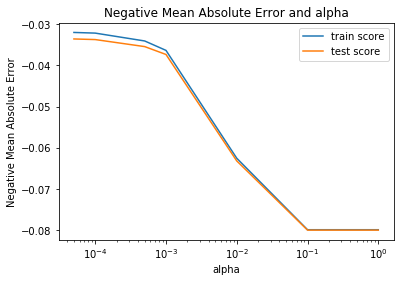

In [93]:
# plotting mean test and train scoes with alpha 
cv_results['param_alpha'] = cv_results['param_alpha'].astype('float32')

# plotting
plt.plot(cv_results['param_alpha'], cv_results['mean_train_score'])
plt.plot(cv_results['param_alpha'], cv_results['mean_test_score'])
plt.xlabel('alpha')
plt.ylabel('Negative Mean Absolute Error')
plt.xscale('log')
plt.title("Negative Mean Absolute Error and alpha")
plt.legend(['train score', 'test score'], loc='left left')
plt.show()

In [94]:
# model with optimal alpha
# lasso regression
lm = Lasso(alpha=0.0001)
lm.fit(X_train_rfe, y_train)

# predict
y_train_pred = lm.predict(X_train_rfe)
print(metrics.r2_score(y_true=y_train, y_pred=y_train_pred))
y_test_pred = lm.predict(X_test_rfe)
print(metrics.r2_score(y_true=y_test, y_pred=y_test_pred))

0.818156704692312
0.7822757753366136


In [95]:
# lasso model parameters
model_parameters = list(lm.coef_)
model_parameters.insert(0, lm.intercept_)
model_parameters = [round(x, 3) for x in model_parameters]
cols = X_train_rfe.columns
cols = cols.insert(0, "constant")
lis_coeff_L=list(zip(cols, model_parameters))
sorted(lis_coeff_L, key=lambda x: x[1], reverse=True)

[('LotArea', 0.239),
 ('OverallQual_10', 0.189),
 ('OverallQual_9', 0.149),
 ('constant', 0.143),
 ('OverallQual_8', 0.09),
 ('Neighborhood_NoRidge', 0.074),
 ('FullBath_3', 0.068),
 ('Neighborhood_Crawfor', 0.054),
 ('2ndFlrSF', 0.051),
 ('BsmtQual_Ex', 0.051),
 ('GarageCars_3', 0.046),
 ('Fireplaces_2', 0.043),
 ('OverallQual_7', 0.04),
 ('GarageCars_4', 0.035),
 ('GarageFinish_Fin', 0.033),
 ('OverallCond_8', 0.032),
 ('GarageFinish_RFn', 0.029),
 ('FireplaceQu_Ex', 0.028),
 ('OverallCond_7', 0.026),
 ('OverallCond_9', 0.024),
 ('SaleType_Con', 0.017),
 ('OverallCond_6', 0.015),
 ('Exterior2nd_ImStucc', 0.014),
 ('Exterior1st_ImStucc', -0.0),
 ('BsmtFinType1_Absent', -0.027),
 ('age_build', -0.105)]

# Q & A

### 1 . Double alpha:

### Ridge:

In [96]:
alpha = 1
ridge = Ridge(alpha=alpha)

ridge.fit(X_train_rfe, y_train)
# predict
y_train_pred = ridge.predict(X_train_rfe)
print(metrics.r2_score(y_true=y_train, y_pred=y_train_pred))
y_test_pred = ridge.predict(X_test_rfe)
print(metrics.r2_score(y_true=y_test, y_pred=y_test_pred))

0.8182717159296999
0.7785987166257213


In [97]:
# Ridge model parameters
model_parameters_R_Q1 = list(ridge.coef_)
model_parameters_R_Q1.insert(0, ridge.intercept_)
model_parameters_R_Q1 = [round(x, 3) for x in model_parameters_R_Q1]
cols = X_train_rfe.columns
cols = cols.insert(0, "constant")

lis_coeff_Q1=list(zip(cols, model_parameters_R_Q1))
sorted(lis_coeff_Q1, key=lambda x: x[1], reverse=True)

[('LotArea', 0.196),
 ('OverallQual_10', 0.177),
 ('constant', 0.143),
 ('OverallQual_9', 0.143),
 ('OverallQual_8', 0.087),
 ('Neighborhood_NoRidge', 0.077),
 ('FullBath_3', 0.069),
 ('Neighborhood_Crawfor', 0.054),
 ('BsmtQual_Ex', 0.054),
 ('2ndFlrSF', 0.051),
 ('GarageCars_3', 0.048),
 ('GarageCars_4', 0.048),
 ('SaleType_Con', 0.046),
 ('Fireplaces_2', 0.045),
 ('OverallQual_7', 0.04),
 ('OverallCond_8', 0.034),
 ('GarageFinish_Fin', 0.034),
 ('FireplaceQu_Ex', 0.033),
 ('OverallCond_9', 0.031),
 ('GarageFinish_RFn', 0.031),
 ('Exterior2nd_ImStucc', 0.029),
 ('OverallCond_7', 0.027),
 ('OverallCond_6', 0.016),
 ('BsmtFinType1_Absent', -0.029),
 ('Exterior1st_ImStucc', -0.05),
 ('age_build', -0.105)]

### Lasso:

In [98]:

lm = Lasso(alpha=0.0002)
lm.fit(X_train_rfe, y_train)

# predict
y_train_pred = lm.predict(X_train_rfe)
print(metrics.r2_score(y_true=y_train, y_pred=y_train_pred))
y_test_pred = lm.predict(X_test_rfe)
print(metrics.r2_score(y_true=y_test, y_pred=y_test_pred))

0.8146997486618163
0.7776084059124018


In [99]:
# lasso model parameters
model_parameters_Q1 = list(lm.coef_)
model_parameters_Q1.insert(0, lm.intercept_)
model_parameters_Q1 = [round(x, 3) for x in model_parameters_Q1]
cols = X_train_rfe.columns
cols = cols.insert(0, "constant")

lis_coeff_l_Q1=list(zip(cols, model_parameters_Q1))
sorted(lis_coeff_l_Q1, key=lambda x: x[1], reverse=True)

[('LotArea', 0.194),
 ('OverallQual_10', 0.182),
 ('constant', 0.145),
 ('OverallQual_9', 0.143),
 ('OverallQual_8', 0.088),
 ('Neighborhood_NoRidge', 0.073),
 ('FullBath_3', 0.068),
 ('BsmtQual_Ex', 0.052),
 ('2ndFlrSF', 0.05),
 ('Neighborhood_Crawfor', 0.05),
 ('GarageCars_3', 0.047),
 ('Fireplaces_2', 0.045),
 ('OverallQual_7', 0.04),
 ('GarageFinish_Fin', 0.034),
 ('GarageFinish_RFn', 0.03),
 ('OverallCond_8', 0.026),
 ('FireplaceQu_Ex', 0.025),
 ('OverallCond_7', 0.023),
 ('OverallCond_9', 0.014),
 ('GarageCars_4', 0.014),
 ('OverallCond_6', 0.012),
 ('Exterior1st_ImStucc', -0.0),
 ('Exterior2nd_ImStucc', 0.0),
 ('SaleType_Con', 0.0),
 ('BsmtFinType1_Absent', -0.025),
 ('age_build', -0.099)]

### Q3: 
    Remove top 5 variables and build Lasso model.

In [100]:
# top5 variables
top5 = ['LotArea','OverallQual_10','OverallQual_9','OverallQual_8','age_build']

#Remove top 5 variable from X_train_rfe
X_train_rfe_q3 = X_train_rfe.drop(top5,axis=1)

#Remove top 5 variable from X_test_rfe
X_test_rfe_q3 = X_test_rfe.drop(top5,axis=1)
X_test_rfe_q3.shape

(438, 20)

In [101]:

lm_q3 = Lasso(alpha=0.0002)
lm_q3.fit(X_train_rfe_q3, y_train)

# predict
y_train_pred = lm_q3.predict(X_train_rfe_q3)
print(metrics.r2_score(y_true=y_train, y_pred=y_train_pred))
y_test_pred = lm_q3.predict(X_test_rfe_q3)
print(metrics.r2_score(y_true=y_test, y_pred=y_test_pred))

0.7086950300405161
0.6463355548044991


In [102]:
# lasso model parameters
model_parameters_Q3 = list(lm_q3.coef_)
model_parameters_Q3.insert(0, lm_q3.intercept_)
model_parameters_Q3 = [round(x, 3) for x in model_parameters_Q3]
cols = X_train_rfe_q3.columns
cols = cols.insert(0, "constant")

lis_coeff_l_Q3=list(zip(cols, model_parameters_Q3))
sorted(lis_coeff_l_Q3, key=lambda x: x[1], reverse=True)

[('constant', 0.124),
 ('Neighborhood_NoRidge', 0.105),
 ('BsmtQual_Ex', 0.102),
 ('FullBath_3', 0.095),
 ('GarageCars_3', 0.093),
 ('GarageFinish_Fin', 0.074),
 ('GarageFinish_RFn', 0.061),
 ('Fireplaces_2', 0.058),
 ('FireplaceQu_Ex', 0.05),
 ('2ndFlrSF', 0.047),
 ('Neighborhood_Crawfor', 0.043),
 ('OverallQual_7', 0.023),
 ('SaleType_Con', 0.013),
 ('GarageCars_4', 0.003),
 ('OverallCond_7', 0.0),
 ('OverallCond_8', 0.0),
 ('OverallCond_9', 0.0),
 ('Exterior1st_ImStucc', -0.0),
 ('Exterior2nd_ImStucc', 0.0),
 ('OverallCond_6', -0.005),
 ('BsmtFinType1_Absent', -0.038)]